# Setup

In [1]:
import argparse
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from tqdm.auto import tqdm
import matplotlib
import traceback
import sys

from utils import *
from compare_uid import *
matplotlib.use('nbAgg')

[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [2]:
%matplotlib inline

# Data Prep

In [22]:
UID_metrics = load_metrics_files(Path("../UID_Analysis").iterdir())

Loaded metrics from mistral-7b-instruct-v0.1@q8_0/daily_dialog: 300 texts
Loaded metrics from mistral-7b-instruct-v0.1@q8_0/old_analysis: 300 texts
Loaded metrics from mistral-7b-instruct-v0.1@q8_0/cnn_dailymail: 300 texts
Loaded metrics from mistral-7b-instruct-v0.1@q8_0/WildChat: 160 texts
Loaded metrics from mistral-7b-instruct-v0.1@q8_0/writingprompts: 300 texts
Total files loaded: 5
Loaded metrics from llama-2-7b-chat@q8_0/daily_dialog: 300 texts
Loaded metrics from llama-2-7b-chat@q8_0/old_analysis: 300 texts
Loaded metrics from llama-2-7b-chat@q8_0/cnn_dailymail: 300 texts
Loaded metrics from llama-2-7b-chat@q8_0/WildChat: 159 texts
Loaded metrics from llama-2-7b-chat@q8_0/writingprompts: 300 texts
Total files loaded: 10
Loaded metrics from llama-2-7b@q8_0/daily_dialog: 296 texts
Loaded metrics from llama-2-7b@q8_0/old_analysis: 2000 texts
Loaded metrics from llama-2-7b@q8_0/cnn_dailymail: 300 texts
Loaded metrics from llama-2-7b@q8_0/WildChat: 145 texts
Loaded metrics from llam

In [23]:
UID_metrics.shape

(11018, 12)

In [24]:
UID_metrics['model'].value_counts()

model
llama-2-7b@q8_0                  3041
mistral-7b-instruct-v0.1@q8_0    1360
llama-2-7b-chat@q8_0             1359
mistral-plus-7b@q8_0             1359
llama-2-7b-32k-instruct@q8_0     1352
mistral-7b-v0.1@q8_0             1347
human_texts                      1200
Name: count, dtype: int64

In [25]:
human = ['human_texts']
base_lm = [
    'llama-2-7b@q8_0', 
    'mistral-7b-v0.1@q8_0',
    ]
instruct = [
    'llama-2-7b-32k-instruct@q8_0',
    # 'mistral-7b-instruct-v0.3', 
    'mistral-7b-instruct-v0.1@q8_0',
    ]
chat = ['llama-2-7b-chat@q8_0', 
        'mistral-plus-7b@q8_0']

UID_metrics['model_class'] = UID_metrics['model'].apply(lambda model: 'human' if model in human 
                                                      else 'base' if model in base_lm
                                                      else 'instruct' if model in instruct 
                                                      else 'chat' if model in chat
                                                      else 'other')
UID_metrics = UID_metrics[UID_metrics['model_class'] != 'other']
UID_metrics = UID_metrics[UID_metrics['dataset'] != "old_analysis"]

In [26]:
UID_metrics['model'].value_counts()

model
mistral-7b-instruct-v0.1@q8_0    1060
llama-2-7b-chat@q8_0             1059
mistral-plus-7b@q8_0             1059
llama-2-7b-32k-instruct@q8_0     1052
mistral-7b-v0.1@q8_0             1047
llama-2-7b@q8_0                  1041
human_texts                       900
Name: count, dtype: int64

In [27]:
UID_metrics['dataset'].value_counts()

dataset
writingprompts    2099
cnn_dailymail     2098
daily_dialog      2081
WildChat           940
Name: count, dtype: int64

In [28]:
# subsampling based on model and model class
def subsample_by_col(df, col):
    """
    Subsample the dataframe based on the specified column.
    """
    min_count = df[col].value_counts().min()
    subsampled_df = (df.groupby(col)
                     .apply(lambda x: x.sample(min_count, replace=False, random_state=42))
                     .reset_index(drop=True))
    return subsampled_df

subsamp_model = subsample_by_col(UID_metrics, 'model')
subsamp_model_class = subsample_by_col(UID_metrics, 'model_class')
subsamp_dataset = subsample_by_col(UID_metrics, 'dataset')

/var/folders/sj/59v4c3dd1r1brq_2d_bjy80w0000gn/T/ipykernel_3064/2879656433.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, replace=False, random_state=42))
/var/folders/sj/59v4c3dd1r1brq_2d_bjy80w0000gn/T/ipykernel_3064/2879656433.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, replace=False, random_state=42))
/var/folders/sj/

In [29]:
UID_metrics.to_csv("analysis_csvs/all_uid_metrics.csv", index=False)
subsamp_model.to_csv("analysis_csvs/subsample_by_model.csv", index=False)
subsamp_dataset.to_csv("analysis_csvs/subsample_by_dataset.csv", index=False)

# Model UID Analysis

In [31]:
UID_metrics.head()

,filename,tokens,mean_surprisal,median_surprisal,min_surprisal,max_surprisal,uid_variance,uid_pairwise,vocab_size,sentence_length,model,dataset,model_class
1360,llama-2-7b-chat@q8_0_27.csv,136,3.856279,2.692792,0.000308,16.429991,11.700478,22.988484,96.0,10.300000,llama-2-7b-chat@q8_0,daily_dialog,chat
1361,llama-2-7b-chat@q8_0_33.csv,38,4.525055,2.991564,0.237242,19.923351,19.250896,48.966890,33.0,9.333333,llama-2-7b-chat@q8_0,daily_dialog,chat
1362,llama-2-7b-chat@q8_0_181.csv,11,4.622656,3.088513,1.362359,11.627416,12.478117,24.212457,11.0,3.500000,llama-2-7b-chat@q8_0,daily_dialog,chat
1363,llama-2-7b-chat@q8_0_195.csv,52,4.264880,3.098283,0.002340,23.318491,16.678468,32.742362,44.0,11.000000,llama-2-7b-chat@q8_0,daily_dialog,chat
1364,llama-2-7b-chat@q8_0_142.csv,8,6.356381,5.809477,1.506889,14.477957,20.948413,46.208484,8.0,6.000000,llama-2-7b-chat@q8_0,daily_dialog,chat


In [32]:
UID_metrics.groupby("model_class").apply(lambda df: df.describe().loc[['mean', 'std']])

/var/folders/sj/59v4c3dd1r1brq_2d_bjy80w0000gn/T/ipykernel_39915/3489711922.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  UID_metrics.groupby("model_class").apply(lambda df: df.describe().loc[['mean', 'std']])


tokens  mean_surprisal  median_surprisal  min_surprisal  \
model_class                                                                     
base        mean  312.943938        4.281332          3.296349       0.071582   
            std   340.340719        1.251435          1.563488       0.423440   
chat        mean  245.515085        3.990332          3.072611       0.038645   
            std   218.022902        0.735295          0.825707       0.240777   
human       mean  529.657500        4.970888          3.881324       0.028710   
            std   346.233088        0.742112          0.786892       0.146025   
instruct    mean  671.731509        3.448679          2.435110       0.024307   
            std   419.085960        1.225696          1.479798       0.203963   

                  max_surprisal  uid_variance  uid_pairwise  vocab_size  \
model_class                                                               
base        mean      20.587095     16.898434     31.523801  199.492816   
            std        8.758011     21.759003     42.345759  120.367039   
chat        mean      19.159963     13.206055     25.735145  139.751180   
            std        5.860872      6.664508     12.819183   87.507953   
human       mean      22.643851     18.389676     35.592437         NaN   
            std        3.625535      4.352748      8.380943         NaN   
instruct    mean      21.133339     12.381724     22.493946  241.060837   
            std        7.554980      5.093324     11.759160  125.733631   

                  sentence_length  
model_class                        
base        mean        19.596826  
            std         19.703696  
chat        mean        17.329434  
            std          8.829862  
human       mean              NaN  
            std               NaN  
instruct    mean        18.950883  
            std         23.714814

In [33]:
UID_metrics.groupby(["dataset", "model"]).apply(lambda df: df.describe().loc[['mean']])

/var/folders/sj/59v4c3dd1r1brq_2d_bjy80w0000gn/T/ipykernel_39915/1935143797.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  UID_metrics.groupby(["dataset", "model"]).apply(lambda df: df.describe().loc[['mean']])


tokens  mean_surprisal  \
dataset        model                                                            
WildChat       llama-2-7b-32k-instruct@q8_0 mean   657.405063        3.502814   
               llama-2-7b-chat@q8_0         mean   604.861635        3.622987   
               llama-2-7b@q8_0              mean   644.737931        3.727465   
               mistral-7b-v0.1@q8_0         mean   576.188679        3.833294   
               mistral-plus-7b@q8_0         mean   369.779874        4.019784   
cnn_dailymail  human_texts                  mean   742.756667        4.344916   
               llama-2-7b-32k-instruct@q8_0 mean  1002.073826        2.896543   
               llama-2-7b-chat@q8_0         mean   323.036667        3.573186   
               llama-2-7b@q8_0              mean   421.273333        4.216886   
               mistral-7b-v0.1@q8_0         mean   426.936667        3.984512   
               mistral-plus-7b@q8_0         mean   258.573333        4.196171   
daily_dialog   human_texts                  mean   122.053333        5.360219   
               llama-2-7b-32k-instruct@q8_0 mean   367.188552        3.695413   
               llama-2-7b-chat@q8_0         mean    69.620000        4.444245   
               llama-2-7b@q8_0              mean   509.503378        3.876895   
               mistral-7b-v0.1@q8_0         mean   143.569444        4.489923   
               mistral-plus-7b@q8_0         mean   140.933333        4.101328   
old_analysis   human_texts                  mean   626.910000        5.089209   
               llama-2-7b-32k-instruct@q8_0 mean   398.276667        3.993493   
               llama-2-7b-chat@q8_0         mean   114.860000        3.889432   
               llama-2-7b@q8_0              mean   128.369000        4.623964   
               mistral-7b-v0.1@q8_0         mean   316.710000        3.709316   
               mistral-plus-7b@q8_0         mean   143.963333        3.789976   
writingprompts human_texts                  mean   626.910000        5.089209   
               llama-2-7b-32k-instruct@q8_0 mean   926.939799        3.178641   
               llama-2-7b-chat@q8_0         mean   317.080000        4.011128   
               llama-2-7b@q8_0              mean   662.703333        4.053173   
               mistral-7b-v0.1@q8_0         mean   636.370000        3.862523   
               mistral-plus-7b@q8_0         mean   339.740000        4.096276   

                                                  median_surprisal  \
dataset        model                                                 
WildChat       llama-2-7b-32k-instruct@q8_0 mean          2.277535   
               llama-2-7b-chat@q8_0         mean          2.366361   
               llama-2-7b@q8_0              mean          2.648859   
               mistral-7b-v0.1@q8_0         mean          2.710638   
               mistral-plus-7b@q8_0         mean          2.866363   
cnn_dailymail  human_texts                  mean          3.270224   
               llama-2-7b-32k-instruct@q8_0 mean          1.823218   
               llama-2-7b-chat@q8_0         mean          2.602029   
               llama-2-7b@q8_0              mean          3.358580   
               mistral-7b-v0.1@q8_0         mean          3.170185   
               mistral-plus-7b@q8_0         mean          3.333039   
daily_dialog   human_texts                  mean          4.155957   
               llama-2-7b-32k-instruct@q8_0 mean          2.756680   
               llama-2-7b-chat@q8_0         mean          3.550305   
               llama-2-7b@q8_0              mean          3.260744   
               mistral-7b-v0.1@q8_0         mean          3.846974   
               mistral-plus-7b@q8_0         mean          3.283841   
old_analysis   human_texts                  mean          4.049557   
               llama-2-7b-32k-instruct@q8_0 mean          3.064566   
               llama-2-7b-chat@q8_0         mean          2.931760   
   

In [34]:
UID_metrics['model'].value_counts()

model
llama-2-7b@q8_0                 3041
llama-2-7b-chat@q8_0            1359
mistral-plus-7b@q8_0            1359
llama-2-7b-32k-instruct@q8_0    1352
mistral-7b-v0.1@q8_0            1347
human_texts                     1200
Name: count, dtype: int64

In [34]:
main_cmap = {
    'human': 'firebrick',
    'base': 'lightslategrey',
    'instruct': 'lightblue',
    'chat': 'steelblue',
}
main_cmap.update({
    'human_texts': main_cmap['human'],
    ####
    'llama-2-7b': main_cmap['base'],
    'mistral-7b-v0.1': main_cmap['base'],
    ####
    'llama-2-7b-32k-instruct': main_cmap['instruct'],
    'mistral-instruct-01': main_cmap['instruct'],
    ####
    'llama-2-7b-chat': main_cmap['chat'],
    'mistral-plus-7b': main_cmap['chat']
})

Text(0.5, 1.0, 'Mean vs. median surprisal values')

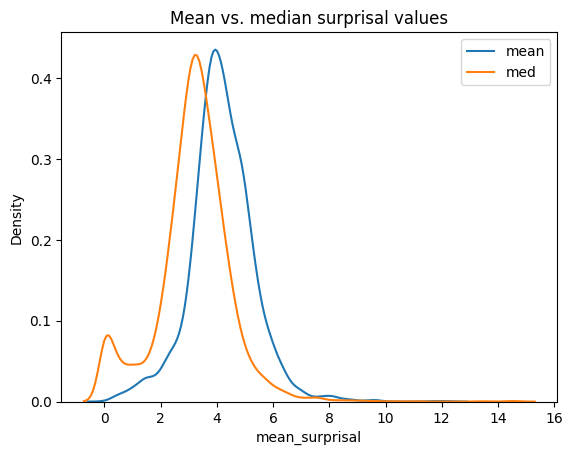

In [56]:
sns.kdeplot(data=subsamp_model_class, x='mean_surprisal', label='mean')
sns.kdeplot(data=subsamp_model_class, x='median_surprisal', label='med')
plt.legend()
plt.title("Mean vs. median surprisal values")

(0.0, 1024.0)

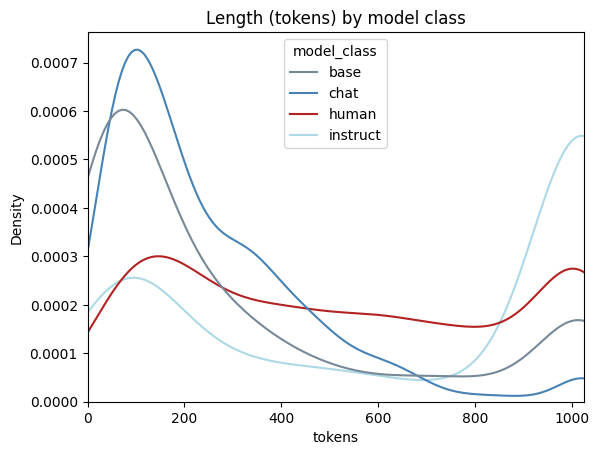

In [57]:
sns.kdeplot(data=subsamp_model_class, x='tokens', hue='model_class', palette=main_cmap)
plt.title("Length (tokens) by model class")
plt.xlim(0, 1024)

(0.0, 1024.0)

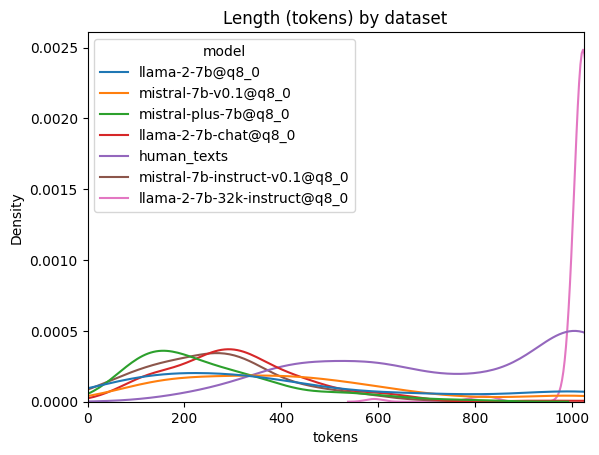

In [36]:
sns.kdeplot(data=subsamp_model_class[subsamp_model_class['dataset'] == 'cnn_dailymail'], 
            x='tokens', hue='model')
plt.title("Length (tokens) by dataset")
plt.xlim(0, 1024)

<Axes: xlabel='mean_surprisal', ylabel='Density'>

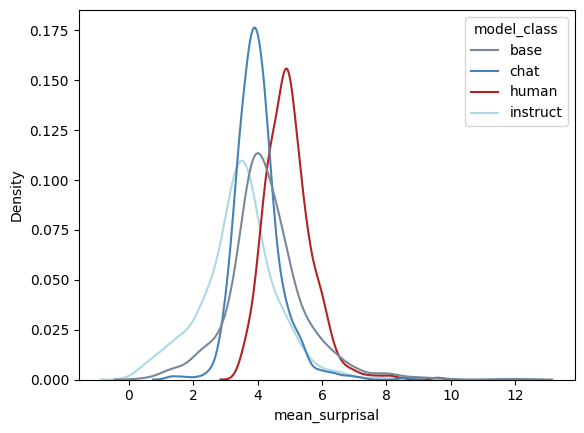

In [59]:
sns.kdeplot(data=subsamp_model_class, x='mean_surprisal', hue='model_class', palette=main_cmap)

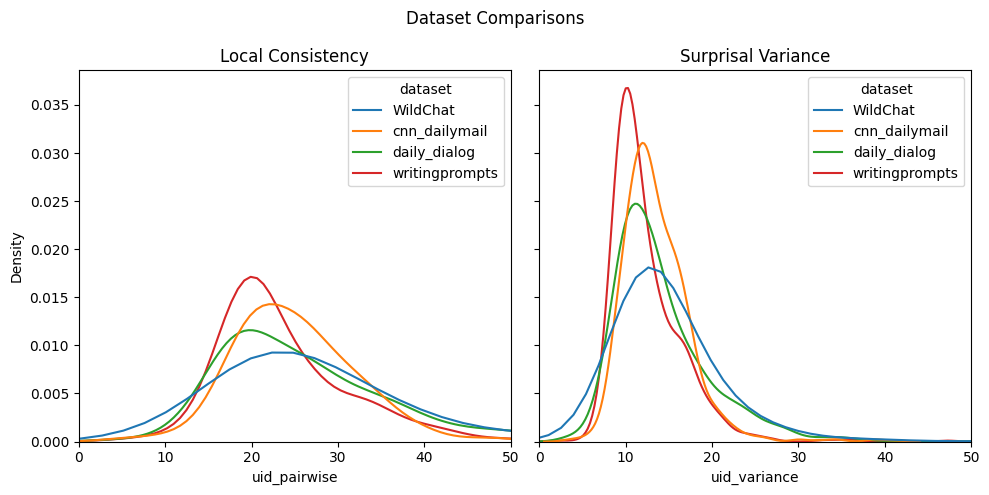

In [40]:
def plot_uid_measures(df, hue='model', titles=("Local consistency", "Surprisal variance"), suptitle="", cmap=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

    sns.kdeplot(data=df, x='uid_pairwise', hue=hue, ax=axs[0], palette=cmap)
    axs[0].set_xlim(0, 50)
    axs[0].set_title(titles[0].title())

    sns.kdeplot(data=df, x='uid_variance', hue=hue, ax=axs[1], palette=cmap)
    axs[1].set_title(titles[1].title())

    plt.suptitle(suptitle.title())
    plt.tight_layout()
plot_uid_measures(subsamp_dataset, hue='dataset', suptitle='Dataset Comparisons')

In [25]:
UID_metrics['model'].value_counts()

model
llama-2-7b@q8_0                 2757
human_texts                     1200
llama-2-7b-32k-instruct@q8_0    1050
llama-2-7b-chat@q8_0            1050
mistral-7b-v0.1@q8_0            1050
mistral-plus-7b@q8_0             900
Name: count, dtype: int64

In [19]:
llama_models = ['llama-2-7b', 'llama-2-7b-32k-instruct', 'llama-2-7b-chat']
mistral_models = ['mistral-7b-v0.1', 'mistral-instruct-01', 'mistral-plus-7b']

llama_metrics = subsamp_model[subsamp_model['model'].isin(llama_models + ['human_texts'])]
mistral_metrics = subsamp_model[subsamp_model['model'].isin(mistral_models + ['human_texts'])]

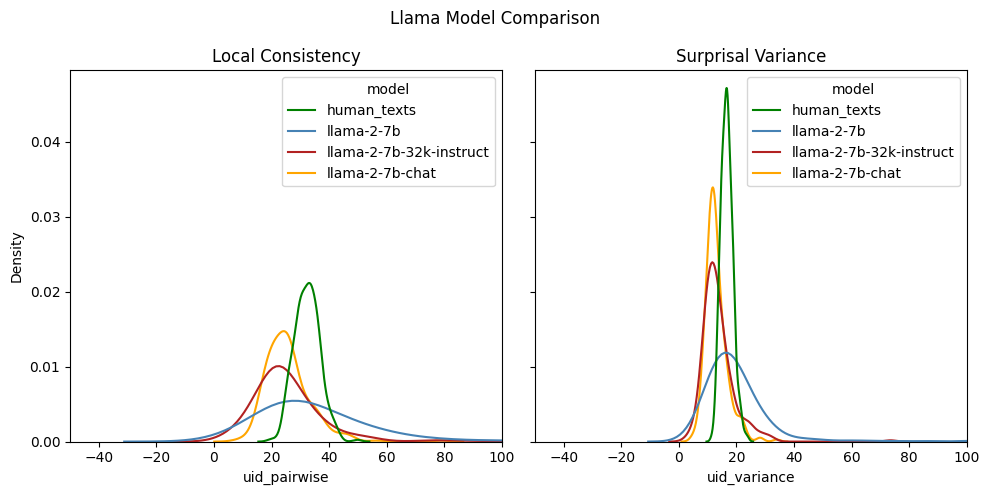

In [106]:
plot_uid_measures(llama_metrics, hue='model', suptitle="Llama model comparison", cmap=main_cmap)

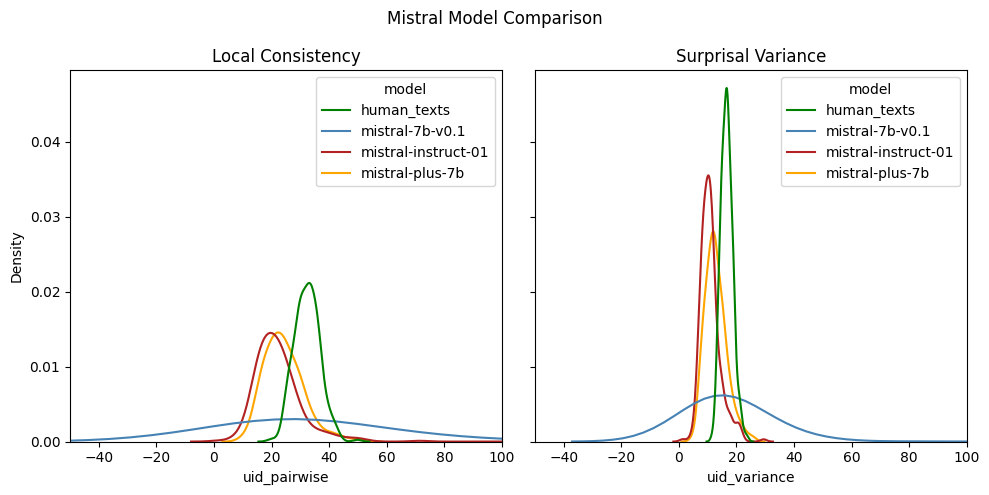

In [107]:
plot_uid_measures(mistral_metrics, hue='model', suptitle="mistral model comparison", cmap=main_cmap)

# Domain Analysis

In [39]:
metrics = subsamp_model_class

humans_only = metrics[metrics['model'] == "human_texts"]

C:\Users\tianq\AppData\Local\Temp\ipykernel_19624\4249752321.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_uid_measures(humans_only[subsamp_model_class['dataset'] != "old_analysis"], hue='dataset', suptitle='Model Class Comparisons')


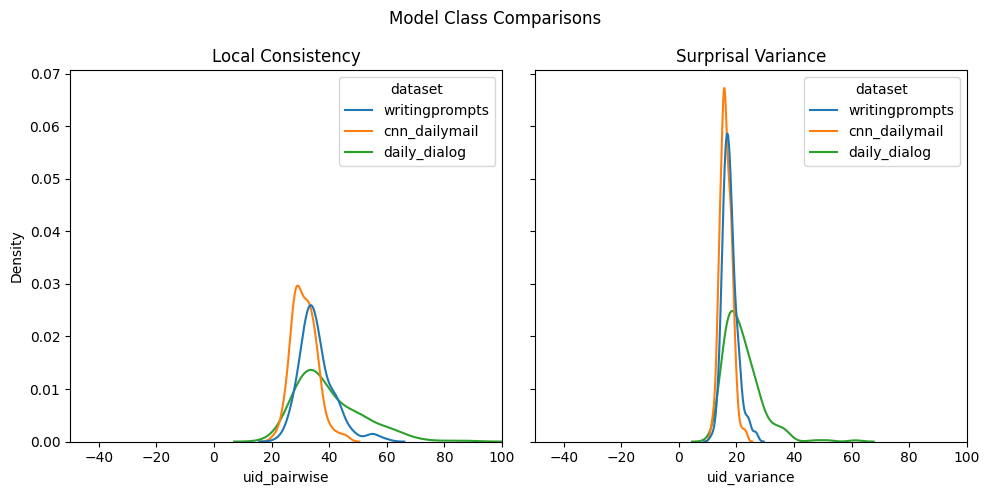

In [40]:
plot_uid_measures(humans_only[subsamp_model_class['dataset'] != "old_analysis"], hue='dataset', suptitle='Model Class Comparisons')

# Statistical Testing

## KS-Test

In [108]:
from scipy.stats import ks_2samp

In [109]:
# comparing models to human
metric = 'uid_variance'
n_unique_models = UID_metrics['model'].nunique()
all_models = UID_metrics['model'].unique()
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_results[model] = result
model_results

{'human_texts': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(11.338586177765642), statistic_sign=np.int8(1)),
 'llama-2-7b': KstestResult(statistic=np.float64(0.2955), pvalue=np.float64(2.1438462913993263e-77), statistic_location=np.float64(20.100794017601885), statistic_sign=np.int8(-1)),
 'llama-2-7b-32k-instruct': KstestResult(statistic=np.float64(0.553), pvalue=np.float64(9.620252363063907e-75), statistic_location=np.float64(14.062003121620585), statistic_sign=np.int8(1)),
 'llama-2-7b-chat': KstestResult(statistic=np.float64(0.6178333333333333), pvalue=np.float64(4.382201874450111e-95), statistic_location=np.float64(14.054966771711786), statistic_sign=np.int8(1)),
 'mistral-7b-v0.1': KstestResult(statistic=np.float64(0.399), pvalue=np.float64(8.270760859355696e-38), statistic_location=np.float64(13.209420799630436), statistic_sign=np.int8(1)),
 'mistral-instruct-01': KstestResult(statistic=np.float64(0.7936666666666666), pvalue=np.f

In [110]:
metric = 'uid_variance'
n_unique_models = UID_metrics['model_class'].nunique()
all_model_classes = UID_metrics['model_class'].unique()
model_class_results = dict()
for model_class in all_model_classes:
    d1 = UID_metrics.loc[UID_metrics['model_class'] == model_class, metric]
    d2 = UID_metrics.loc[UID_metrics['model_class'] == 'human', metric]
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_class_results[model_class] = result
model_class_results

{'human': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(11.338586177765642), statistic_sign=np.int8(1)),
 'base': KstestResult(statistic=np.float64(0.283), pvalue=np.float64(5.858867162014141e-76), statistic_location=np.float64(20.100794017601885), statistic_sign=np.int8(-1)),
 'instruct': KstestResult(statistic=np.float64(0.6591666666666667), pvalue=np.float64(4.021011440751329e-192), statistic_location=np.float64(13.01102194310928), statistic_sign=np.int8(1)),
 'chat': KstestResult(statistic=np.float64(0.5993333333333334), pvalue=np.float64(7.13602454719481e-156), statistic_location=np.float64(13.756461577948546), statistic_sign=np.int8(1))}

Text(0.5, 1.0, 'Ks Test Statistics For Different Models, Comparing To Human')

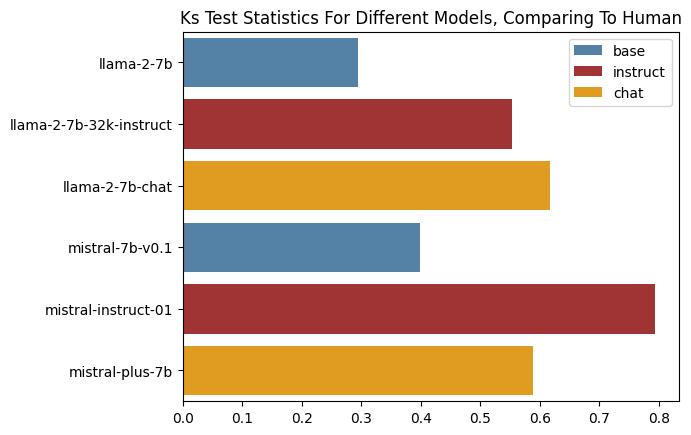

In [111]:
sns.barplot(y=list(model_results.keys())[1:], x=[result.statistic for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("KS Test Statistics for different models, comparing to human".title())

Text(0.5, 1.0, '-Log(Pvalue) For Different Models, Comparing To Human')

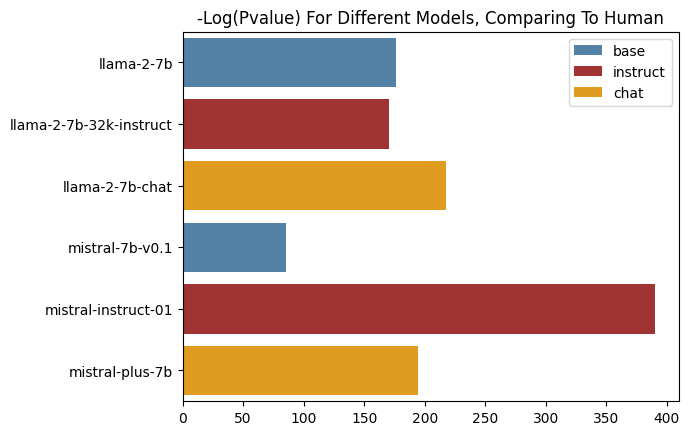

In [114]:
sns.barplot(y=list(model_results.keys())[1:], x=[-np.log(result.pvalue) for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("-log(pvalue) for different models, comparing to human".title())

In [116]:
# testing effect of centering distributions
metric = 'uid_variance'
n_unique_models = UID_metrics['model'].nunique()
all_models = UID_metrics['model'].unique()
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d1 -= d1.mean()
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    d2 -= d2.mean()
    result = ks_2samp(d1, d2, alternative="two-sided")
    model_results[model] = result
model_results

{'human_texts': KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(-5.2065832385089585), statistic_sign=np.int8(1)),
 'llama-2-7b': KstestResult(statistic=np.float64(0.468), pvalue=np.float64(2.9993355631007798e-198), statistic_location=np.float64(-3.0605661327315588), statistic_sign=np.int8(1)),
 'llama-2-7b-32k-instruct': KstestResult(statistic=np.float64(0.2771666666666667), pvalue=np.float64(3.595838020006057e-18), statistic_location=np.float64(-2.4557801822844993), statistic_sign=np.int8(1)),
 'llama-2-7b-chat': KstestResult(statistic=np.float64(0.14916666666666667), pvalue=np.float64(1.579350526583561e-05), statistic_location=np.float64(-1.8911929886334118), statistic_sign=np.int8(1)),
 'mistral-7b-v0.1': KstestResult(statistic=np.float64(0.61), pvalue=np.float64(1.872192688082596e-92), statistic_location=np.float64(-3.1635327125480224), statistic_sign=np.int8(1)),
 'mistral-instruct-01': KstestResult(statistic=np.float64(0.1318333333333

Text(0.5, 1.0, '-Log(Pvalue) For Different Models, Comparing To Human')

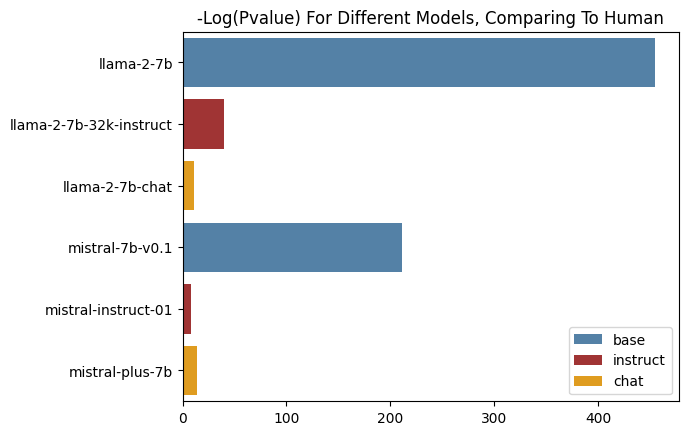

In [117]:
sns.barplot(y=list(model_results.keys())[1:], x=[-np.log(result.pvalue) for result in model_results.values()][1:], hue=['base', 'instruct', 'chat'] * 2, palette=main_cmap)
plt.title("-log(pvalue) for different models, comparing to human".title())

## KL Divergence

In [119]:
from scipy.stats import entropy

In [ ]:
model_results = dict()
for model in all_models:
    d1 = UID_metrics.loc[UID_metrics['model'] == model, metric]
    d2 = UID_metrics.loc[UID_metrics['model'] == 'human_texts', metric]
    d1 = d1.sample(min(len(d1), len(d2)))
    result = entropy(pk=d1, qk=d2)
    model_results[model] = result
model_results

ValueError: Array shapes are incompatible for broadcasting.

# Classification

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
import xgboost as xgb

## Predicting Model from UID

In [15]:
subsamp_model['model'] = pd.factorize(subsamp_model['model'], sort=True)[0]
subsamp_model['model_class'] = pd.factorize(subsamp_model['model_class'], sort=True)[0]
subsamp_model['model'].value_counts()

model
0    300
1    300
2    300
3    300
4    300
5    300
6    300
Name: count, dtype: int64

In [16]:
X = subsamp_model[['tokens', 'mean_surprisal', 'median_surprisal', 'min_surprisal', 'max_surprisal', 'uid_variance', 'uid_pairwise']]
y = subsamp_model['model_class']
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.8, random_state=42)

In [ ]:
rf_cls = RandomForestClassifier(max_depth=7, n_estimators=100)
rf_cls.fit(X_train, y_train)
rf_cls.score(X_train, y_train), rf_cls.score(X_test, y_test)

(0.7755208333333333, 0.6875)

In [ ]:
xgb_cls = xgb.XGBClassifier(max_depth=7, n_estimators=100)
xgb_cls.fit(X_train, y_train)
xgb_cls.score(X_test, y_test)

0.6520833333333333

In [ ]:
xgb_rf = xgb.XGBRFClassifier(max_depth=7, n_estimators=100)
xgb_rf.fit(X_train, y_train)
xgb_rf.score(X_test, y_test)

0.6791666666666667

## Predicting Model Class from UID

In [17]:
subsamp_model_class = (UID_metrics.groupby('model_class')
              .apply(lambda df: df.sample(300, replace=False, random_state=42))
              .reset_index(drop=True))
subsamp_model_class['model'] = pd.factorize(subsamp_model_class['model'], sort=True)[0]
subsamp_model_class['model_class'] = pd.factorize(subsamp_model_class['model_class'], sort=True)[0]
subsamp_model_class['model_class'].value_counts()

C:\Users\Tianqi Zhang\AppData\Local\Temp\ipykernel_35780\2176402028.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(300, replace=False, random_state=42))


model_class
0    300
1    300
2    300
3    300
Name: count, dtype: int64

In [18]:
X = subsamp_model_class[['tokens', 'mean_surprisal', 'median_surprisal', 'min_surprisal', 'max_surprisal', 'uid_variance', 'uid_pairwise']]
y = subsamp_model_class['model_class']
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.8, random_state=42)

In [19]:
rf_cls = RandomForestClassifier(max_depth=7, n_estimators=100)
rf_cls.fit(X_train, y_train)
rf_cls.score(X_train, y_train), rf_cls.score(X_test, y_test)

(0.8697916666666666, 0.725)

In [20]:
xgb_cls = xgb.XGBClassifier(max_depth=7, n_estimators=100)
xgb_cls.fit(X_train, y_train)
xgb_cls.score(X_test, y_test)

0.675

In [21]:
xgb_rf = xgb.XGBRFClassifier(max_depth=7, n_estimators=100)
xgb_rf.fit(X_train, y_train)
xgb_rf.score(X_test, y_test)

0.7375